In [36]:
import requests
import pandas as pd
import io
import chess.pgn
from tqdm import tqdm
import re
import chess.engine

import csv as C
import numpy as N
import pandas as P
import matplotlib as M
import scipy as S
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import shapiro
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kruskal
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr

import statsmodels
from statsmodels.stats import multitest

In [ ]:
df = P.read_csv('../Data/chess-noobs.csv') # games of 2 chess noobs from the last 3 months on chess.com

In [38]:
players = ['maximaan', 'SuoknuutiMax']

In [ ]:


df2 = df.copy() # df2 editable version of df

# df2 replace opponents with 'opponent' for easier analysis
df2['white'] = df2['white'].apply(lambda x: x if x in players else 'opponent')
df2['black'] = df2['black'].apply(lambda x: x if x in players else 'opponent')

# if players in target list play one another
dfvs = df[
    (df['white'].isin(players)) &
    (df['black'].isin(players))
].copy()

In [40]:
dfvs = dfvs.drop_duplicates(subset=['moves']) # drop duplicates

In [41]:
dfvs.head

<bound method NDFrame.head of      Unnamed: 0  eco  opening         white         black  white_elo  \
277         277  D00      NaN      maximaan  SuoknuutiMax        720   
278         278  B10      NaN  SuoknuutiMax      maximaan        676   
279         279  B10      NaN  SuoknuutiMax      maximaan        563   
280         280  D20      NaN      maximaan  SuoknuutiMax        703   
281         281  B10      NaN  SuoknuutiMax      maximaan        623   
..          ...  ...      ...           ...           ...        ...   
742         742  C41      NaN  SuoknuutiMax      maximaan        515   
743         743  B07      NaN  SuoknuutiMax      maximaan        508   
746         746  C46      NaN  SuoknuutiMax      maximaan        544   
754         754  C41      NaN  SuoknuutiMax      maximaan        496   
755         755  C45      NaN  SuoknuutiMax      maximaan        505   

     black_elo result time_control                        termination  \
277        333    1-0          6

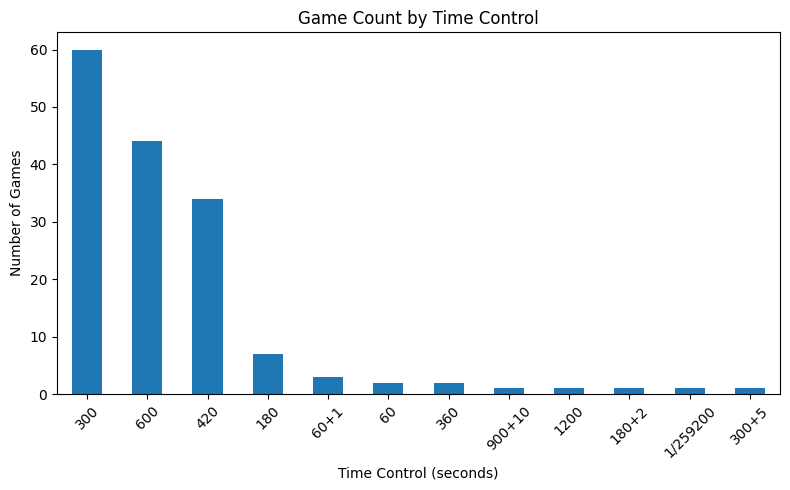

In [42]:
counts = dfvs['time_control'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8,5))
counts.plot(kind='bar')

plt.title('Game Count by Time Control')
plt.xlabel('Time Control (seconds)')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
dfvs['whitewin'] = N.where(dfvs['result'] == '1-0', 1,
                   N.where(dfvs['result'] == '1/2-1/2', 2, 0))

dfvs['blackwin'] = N.where(dfvs['result'] == '0-1', 1,
                   N.where(dfvs['result'] == '1/2-1/2', 2, 0))

In [44]:
dfvs.head

<bound method NDFrame.head of      Unnamed: 0  eco  opening         white         black  white_elo  \
277         277  D00      NaN      maximaan  SuoknuutiMax        720   
278         278  B10      NaN  SuoknuutiMax      maximaan        676   
279         279  B10      NaN  SuoknuutiMax      maximaan        563   
280         280  D20      NaN      maximaan  SuoknuutiMax        703   
281         281  B10      NaN  SuoknuutiMax      maximaan        623   
..          ...  ...      ...           ...           ...        ...   
742         742  C41      NaN  SuoknuutiMax      maximaan        515   
743         743  B07      NaN  SuoknuutiMax      maximaan        508   
746         746  C46      NaN  SuoknuutiMax      maximaan        544   
754         754  C41      NaN  SuoknuutiMax      maximaan        496   
755         755  C45      NaN  SuoknuutiMax      maximaan        505   

     black_elo result time_control                        termination  \
277        333    1-0          6

In [45]:
players_long = P.concat([
    dfvs[['white', 'white_elo', 'whitewin', 'moves', 'termination']].rename(columns={
        'white': 'player', 'white_elo': 'elo', 'whitewin': 'result_flag', 'moves': 'moves', 'termination': 'termination'
    }).assign(color='white'),
    dfvs[['black', 'black_elo', 'blackwin', 'moves', 'termination']].rename(columns={
        'black': 'player', 'black_elo': 'elo', 'blackwin': 'result_flag', 'moves': 'moves', 'termination': 'termination'
    }).assign(color='black')
])

In [46]:
players_long['elo'] = pd.to_numeric(players_long['elo'], errors='coerce')

In [47]:
players_long = players_long.drop(['moves'], axis=1)

In [48]:
players_long.head

<bound method NDFrame.head of            player  elo  result_flag                        termination  color
277      maximaan  720            1          maximaan won by checkmate  white
278  SuoknuutiMax  676            1      SuoknuutiMax won by checkmate  white
279  SuoknuutiMax  563            0          maximaan won by checkmate  white
280      maximaan  703            0    SuoknuutiMax won by resignation  white
281  SuoknuutiMax  623            0        maximaan won by resignation  white
..            ...  ...          ...                                ...    ...
742      maximaan  551            0  SuoknuutiMax won - game abandoned  black
743      maximaan  558            1        maximaan won by resignation  black
746      maximaan  549            0    SuoknuutiMax won by resignation  black
754      maximaan  540            0    SuoknuutiMax won by resignation  black
755      maximaan  531            0    SuoknuutiMax won by resignation  black

[314 rows x 5 columns]>

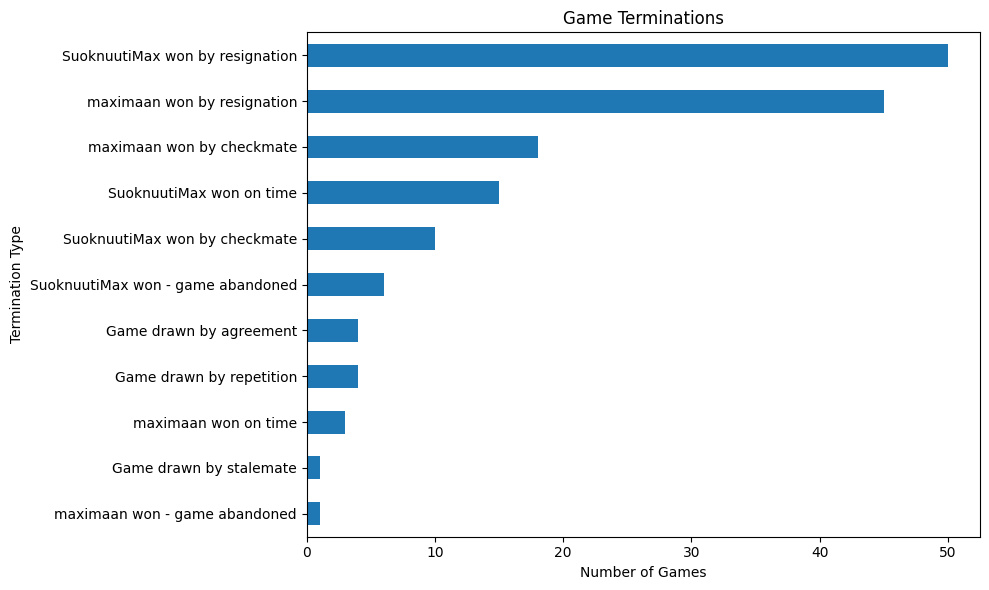

In [49]:


plt.figure(figsize=(10,6))
dfvs['termination'].value_counts().sort_values().plot(kind='barh')

plt.title('Game Terminations')
plt.xlabel('Number of Games')
plt.ylabel('Termination Type')
plt.tight_layout()
plt.show()

In [50]:
dfvs.head

<bound method NDFrame.head of      Unnamed: 0  eco  opening         white         black  white_elo  \
277         277  D00      NaN      maximaan  SuoknuutiMax        720   
278         278  B10      NaN  SuoknuutiMax      maximaan        676   
279         279  B10      NaN  SuoknuutiMax      maximaan        563   
280         280  D20      NaN      maximaan  SuoknuutiMax        703   
281         281  B10      NaN  SuoknuutiMax      maximaan        623   
..          ...  ...      ...           ...           ...        ...   
742         742  C41      NaN  SuoknuutiMax      maximaan        515   
743         743  B07      NaN  SuoknuutiMax      maximaan        508   
746         746  C46      NaN  SuoknuutiMax      maximaan        544   
754         754  C41      NaN  SuoknuutiMax      maximaan        496   
755         755  C45      NaN  SuoknuutiMax      maximaan        505   

     black_elo result time_control                        termination  \
277        333    1-0          6

### Parse + map termination reason and time_control to simpler format

i.e. emit player names from termination, group time controls into broader labels (blitz, bullet, rapid..)

In [51]:
def extract_reason(term):
    term = term.lower()
    if 'resign' in term:
        return 'Resignation'
    elif 'checkmate' in term:
        return 'Checkmate'
    elif 'time' in term:
        return 'On Time'
    elif 'abandon' in term:
        return 'Abandoned'
    elif 'draw' in term or 'stalemate' in term or 'repetition' in term:
        return 'Draw'
    else:
        return 'Other'

dfvs['termination_reason'] = dfvs['termination'].apply(extract_reason)

In [52]:
def parse_time_control(tc):

    if isinstance(tc, (int, float)):
        base = int(tc)
        inc = 0
    elif isinstance(tc, str):
        parts = re.split(r'\+|/', tc)  # handles weird formats like '1/259200'
        try:
            base = int(parts[0])
        except ValueError:
            return None  # skip invalid
        inc = int(parts[1]) if len(parts) > 1 and parts[1].isdigit() else 0
    else:
        return None
    return base, inc


def map_time_category(tc):
    parsed = parse_time_control(tc)
    if parsed is None:
        return 'Other'
    base, inc = parsed

    if base < 180: # emit bullet due to low presence
        pass
    elif base >= 180 and base < 600:
        return 'Blitz'
    elif base < 1800:
        return 'Rapid'
    else:
        pass

In [53]:
dfvs['time_category'] = dfvs['time_control'].apply(map_time_category)

In [54]:
dfvs.groupby(['time_category', 'termination_reason']).size().unstack(fill_value=0)

termination_reason,Abandoned,Checkmate,Draw,On Time,Resignation
time_category,,,,,
Blitz,5,18,5,13,64
Rapid,2,9,3,4,28


In [55]:
dfvs.head

<bound method NDFrame.head of      Unnamed: 0  eco  opening         white         black  white_elo  \
277         277  D00      NaN      maximaan  SuoknuutiMax        720   
278         278  B10      NaN  SuoknuutiMax      maximaan        676   
279         279  B10      NaN  SuoknuutiMax      maximaan        563   
280         280  D20      NaN      maximaan  SuoknuutiMax        703   
281         281  B10      NaN  SuoknuutiMax      maximaan        623   
..          ...  ...      ...           ...           ...        ...   
742         742  C41      NaN  SuoknuutiMax      maximaan        515   
743         743  B07      NaN  SuoknuutiMax      maximaan        508   
746         746  C46      NaN  SuoknuutiMax      maximaan        544   
754         754  C41      NaN  SuoknuutiMax      maximaan        496   
755         755  C45      NaN  SuoknuutiMax      maximaan        505   

     black_elo result time_control                        termination  \
277        333    1-0          6

In [56]:
dfvs['white'].value_counts()

white
SuoknuutiMax    86
maximaan        71
Name: count, dtype: int64

In [57]:
def map_termination(row):
    term = row['termination'].lower()
    player = row['player'].lower()

    # Draw cases
    if 'drawn' in term or 'stalemate' in term:
        return 'draw'

    # Win/loss cases
    if 'won' in term:
        if player in term:        # the player name appears in the text (they won)
            return 'win'
        else:                     # someone else won
            return 'loss'
    
    # Fallback
    return 'other'

In [58]:
players_long['termination_result'] = players_long.apply(map_termination, axis=1)

In [59]:
players_long['termination_result'].value_counts()

termination_result
win     148
loss    148
draw     18
Name: count, dtype: int64

In [60]:
summary = (
    players_long
    .groupby(['player', 'color'])
    .agg(
        wins=('termination_result', lambda x: (x == 'win').sum()),
        losses=('termination_result', lambda x: (x == 'loss').sum()),
        draws=('termination_result', lambda x: (x == 'draw').sum()),
        avg_elo=('elo', 'mean')
    )
    .reset_index()
)

summary['winrate'] = summary['wins'] / (summary['wins'] + summary['losses'] + summary['draws'])
summary

,player,color,wins,losses,draws,avg_elo,winrate
0,SuoknuutiMax,black,33,35,3,595.464789,0.464789
1,SuoknuutiMax,white,48,32,6,591.651163,0.558140
2,maximaan,black,32,48,6,554.325581,0.372093
3,maximaan,white,35,33,3,580.746479,0.492958


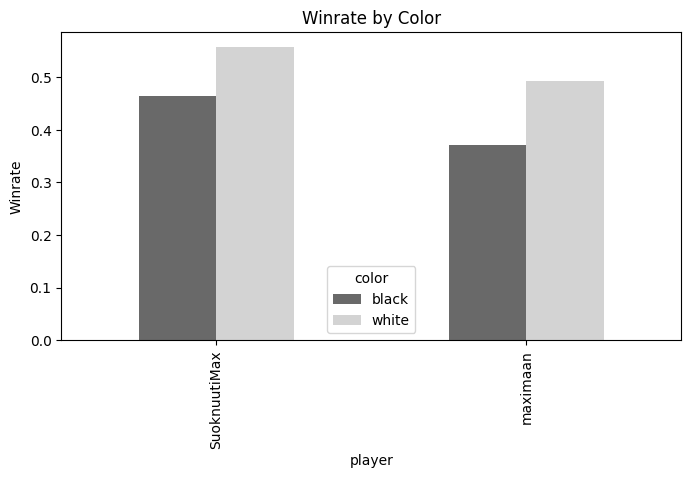

In [61]:
colors=['dimgray','lightgray']
pivot = summary.pivot(index='player', columns='color', values='winrate')
pivot.plot(kind='bar', figsize=(8,4), title='Winrate by Color', color=colors)
plt.ylabel('Winrate')
plt.show()

In [126]:
dfvs['winner'] = dfvs.apply(
    lambda row: row['white'] if row['whitewin'] == 1 
                else (row['black'] if row['blackwin'] == 1 else 'Draw'),
    axis=1
)

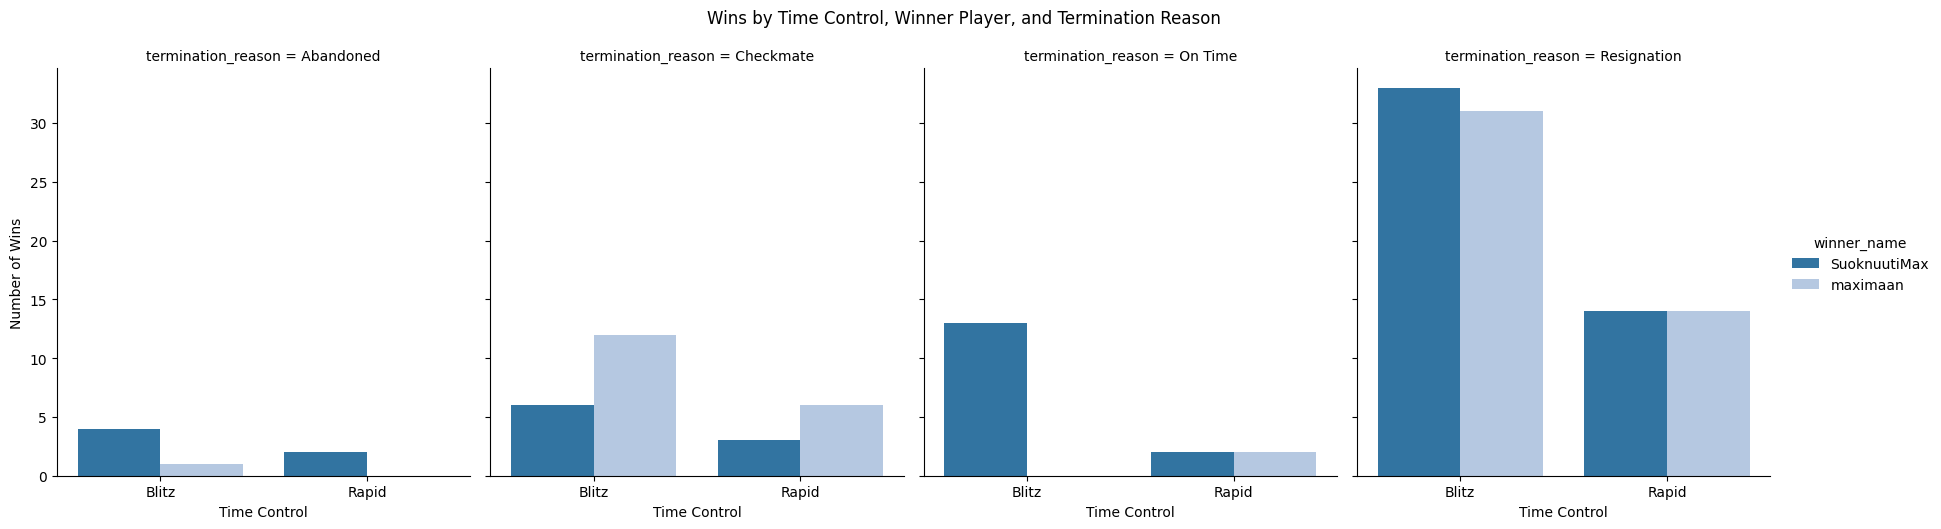

In [127]:
def get_winner_name(row): # map with the names of winners
    if row['whitewin'] == 1:
        return row['white']
    elif row['blackwin'] == 1:
        return row['black']
    else:
        return 'Draw'

dfvs['winner_name'] = dfvs.apply(get_winner_name, axis=1)

# remove draws
df_wins = dfvs[dfvs['winner_name'] != 'Draw']

grouped = (
    df_wins.groupby(['time_category', 'termination_reason', 'winner_name'])
    .size()
    .reset_index(name='count')
)

# catplot
g = sns.catplot(
    data=grouped,
    x='time_category',
    y='count',
    hue='winner_name',
    col='termination_reason',
    kind='bar',
    height=5,
    aspect=0.9,
    palette='tab20'  # lots of colors for multiple players
)

g.set_axis_labels("Time Control", "Number of Wins")
g.fig.suptitle("Wins by Time Control, Winner Player, and Termination Reason", y=1.05)
plt.show()

# Next step: input all the games into a chess engine to get opening, variation and rating for each game

In [128]:
dfvs['date'] = pd.to_datetime(dfvs['date'], format='%Y.%m.%d')
dfvs = dfvs.sort_values(by='date', ascending=False)

In [129]:
dfvs['num_moves_full'] = dfvs['num_moves'] // 2

755    ['e4', 'e5', 'Nf3', 'd6', 'd4', 'Nc6', 'd5', '...
754    ['e4', 'e5', 'Nf3', 'd6', 'Nc3', 'Bg4', 'h3', ...
746    ['e4', 'e5', 'Nf3', 'd6', 'Nc3', 'Nc6', 'd3', ...
743    ['e4', 'e5', 'Nf3', 'd6', 'Nc3', 'Nf6', 'd3', ...
742    ['e4', 'e5', 'Nf3', 'd6', 'd4', 'Bg4', 'dxe5',...
741    ['d4', 'd5', 'c4', 'Nc6', 'c5', 'Nf6', 'e3', '...
740    ['d4', 'd5', 'c4', 'dxc4', 'e4', 'Nc6', 'Nf3',...
735    ['e4', 'e5', 'Nf3', 'Bc5', 'Nc3', 'd6', 'Bc4',...
734    ['d4', 'd5', 'c4', 'dxc4', 'e4', 'Nf6', 'Nc3',...
726    ['e4', 'e5', 'Nf3', 'd6', 'Bc4', 'Bg4', 'd4', ...
725    ['d4', 'd5', 'Bf4', 'Nf6', 'h3', 'Nc6', 'e3', ...
715    ['e4', 'e5', 'Nf3', 'd6', 'Nc3', 'Bg4', 'd4', ...
686    ['e4', 'e5', 'Nf3', 'd6', 'Nc3', 'Bg4', 'Be2',...
684    ['e4', 'e5', 'Nf3', 'd6', 'Nc3', 'Nd7', 'd4', ...
687    ['d4', 'd5', 'Bf4', 'Nc6', 'a3', 'Nf6', 'e3', ...
670    ['d4', 'd5', 'Bf4', 'Nc6', 'e3', 'Nf6', 'h3', ...
671    ['e4', 'e5', 'Nf3', 'd6', 'Nc3', 'Bg4', 'Bc4',...
672    ['d4', 'd5', 'Bf4', 'Nc6

In [155]:
import ast



def to_accuracy(delta, max_loss=200): # helper

    acc = max(0, 100 - (delta / max_loss * 100))
    return min(acc, 100)

def evaluate_from_moves(move_list, engine, depth):
    
    board = chess.Board()
    evals = []

    white_accs = []
    black_accs = []

    for move in move_list:
        try:
            info_before = engine.analyse(board, chess.engine.Limit(depth=depth))
            score_before = info_before["score"].white().score(mate_score=10000)
            
            board.push_san(move)
            
            info_after = engine.analyse(board, chess.engine.Limit(depth=depth))
            score_after = info_after["score"].white().score(mate_score=10000)
            
            if score_after is not None:
                evals.append(score_after)

            if board.turn == chess.BLACK:
                delta = max(0, score_before - score_after)
                white_accs.append(to_accuracy(delta))
            else:
                delta = max(0, score_after - score_before)
                black_accs.append(to_accuracy(delta))
                
        except Exception as e:
            print(f"Error with move '{move}': {e}")
            continue

    avg_eval = sum(evals) / len(evals) if evals else None
    white_accuracy = sum(white_accs)/len(white_accs) if white_accs else None
    black_accuracy = sum(black_accs)/len(black_accs) if black_accs else None


    try:
        opening_name = chess.polyglot.opening_name(board)
    except Exception:
        opening_name = "Unknown"

    return avg_eval, opening_name, white_accuracy, black_accuracy

def evaluate_dataset(dfvs, engine, depth):

    avg_evals = []
    openings = []
    white_accuracies = []
    black_accuracies = []

    for moves_str in dfvs["moves"]:

        moves = ast.literal_eval(moves_str)
         
        moves = [str(m).strip() for m in moves]

        avg_eval, opening, white_acc, black_acc = evaluate_from_moves(moves, engine, depth)
        avg_evals.append(avg_eval)
        openings.append(opening)
        white_accuracies.append(white_acc)
        black_accuracies.append(black_acc)


    dfvs = dfvs.copy()
    dfvs["avg_eval"] = avg_evals
    dfvs["opening"] = openings
    dfvs["white_accuracy"] = white_accuracies
    dfvs["black_accuracy"] = black_accuracies
    
    return dfvs

In [156]:
engine = chess.engine.SimpleEngine.popen_uci("/opt/homebrew/bin/stockfish")

evaluated_df = evaluate_dataset(dfvs, engine, depth=14)

engine.quit()

print(evaluated_df[["avg_eval", 'white', "white_accuracy", 'black', "black_accuracy", 'num_moves_full', 'termination', 'date', 'winner']])

        avg_eval         white  white_accuracy         black  black_accuracy  \
755  1605.353982  SuoknuutiMax       78.833333      maximaan       78.491071   
754   271.720000  SuoknuutiMax       83.807692      maximaan       61.791667   
746   340.054945  SuoknuutiMax       84.663043      maximaan       76.022222   
743  -321.297619  SuoknuutiMax       74.226190      maximaan       80.845238   
742  1039.284672  SuoknuutiMax       81.289855      maximaan       79.213235   
..           ...           ...             ...           ...             ...   
284   193.142857  SuoknuutiMax       76.471698      maximaan       82.500000   
279  -712.266667  SuoknuutiMax       78.933333      maximaan       93.766667   
278   145.869565  SuoknuutiMax       78.456897      maximaan       75.543860   
280  -219.833333      maximaan       61.055556  SuoknuutiMax       90.611111   
277  2048.675676      maximaan       82.026316  SuoknuutiMax       54.277778   

     num_moves_full                    

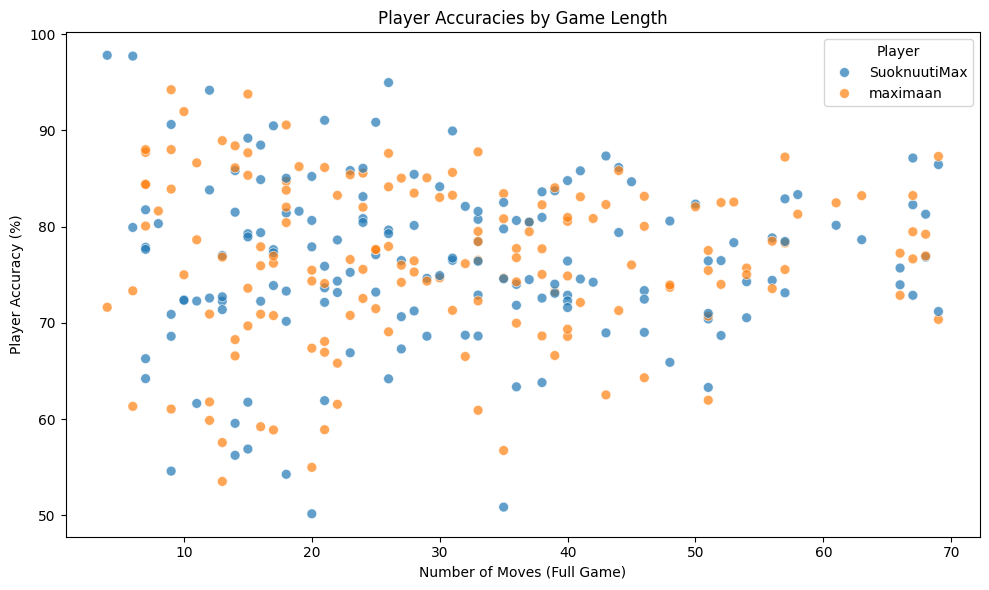

In [157]:
player_points = []

for _, row in evaluated_df.iterrows():
    player_points.append({
        'player': row['white'],
        'accuracy': row['white_accuracy'],
        'num_moves_full': row['num_moves_full']
    })
    player_points.append({
        'player': row['black'],
        'accuracy': row['black_accuracy'],
        'num_moves_full': row['num_moves_full']
    })

player_df = pd.DataFrame(player_points)

plt.figure(figsize=(10,6))

sns.scatterplot(
    data=player_df,
    x='num_moves_full',
    y='accuracy',
    hue='player',
    alpha=0.7,
    s=50
)

plt.xlabel("Number of Moves (Full Game)")
plt.ylabel("Player Accuracy (%)")
plt.title("Player Accuracies by Game Length")
plt.legend(title='Player')
plt.tight_layout()
plt.show()

In [ ]:
evaluated_df.to_csv('../Data/eval-chess-noobs.csv')

In [161]:
evaluated_df['black_accuracy'].max()

np.float64(94.16666666666667)